In [1]:
# # Run this code if you don't have these packages installed
# %pip install nltk
# %pip install numpy
# %pip install pandas
# %pip install sklearn

In [2]:
#Import libraries
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import string
from wordcloud import WordCloud
import imblearn
from imblearn.over_sampling import RandomOverSampler
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier



nltk.download("wordnet")
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moyin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moyin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\moyin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Map POS tag from the Treebank format to the WordNet format for WordNetLemmatizer.
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [4]:
#A tokenizer class that uses lemmatization to process text.
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self,doc):
        tokens = word_tokenize(doc)
        words_and_tags = nltk.pos_tag(tokens)
        return [self.wnl.lemmatize(word,pos = get_wordnet_pos(tag)) \
                 for word,tag in words_and_tags]

In [5]:
# Converting the csv file to a pandas dataframe
path = "data/amazon_reviews.csv"
df = pd.read_csv(path)


In [6]:

#Sorting the data based on the Positive and Negative Reviews and spliting them to words
good_reviews = df[df['feedback'] == 1]
bad_reviews = df[df['feedback'] == 0]
good = good_reviews['verified_reviews'].tolist()
bad = bad_reviews['verified_reviews'].tolist()
good_str = ' '.join(good)
bad_str = ' '.join(bad)


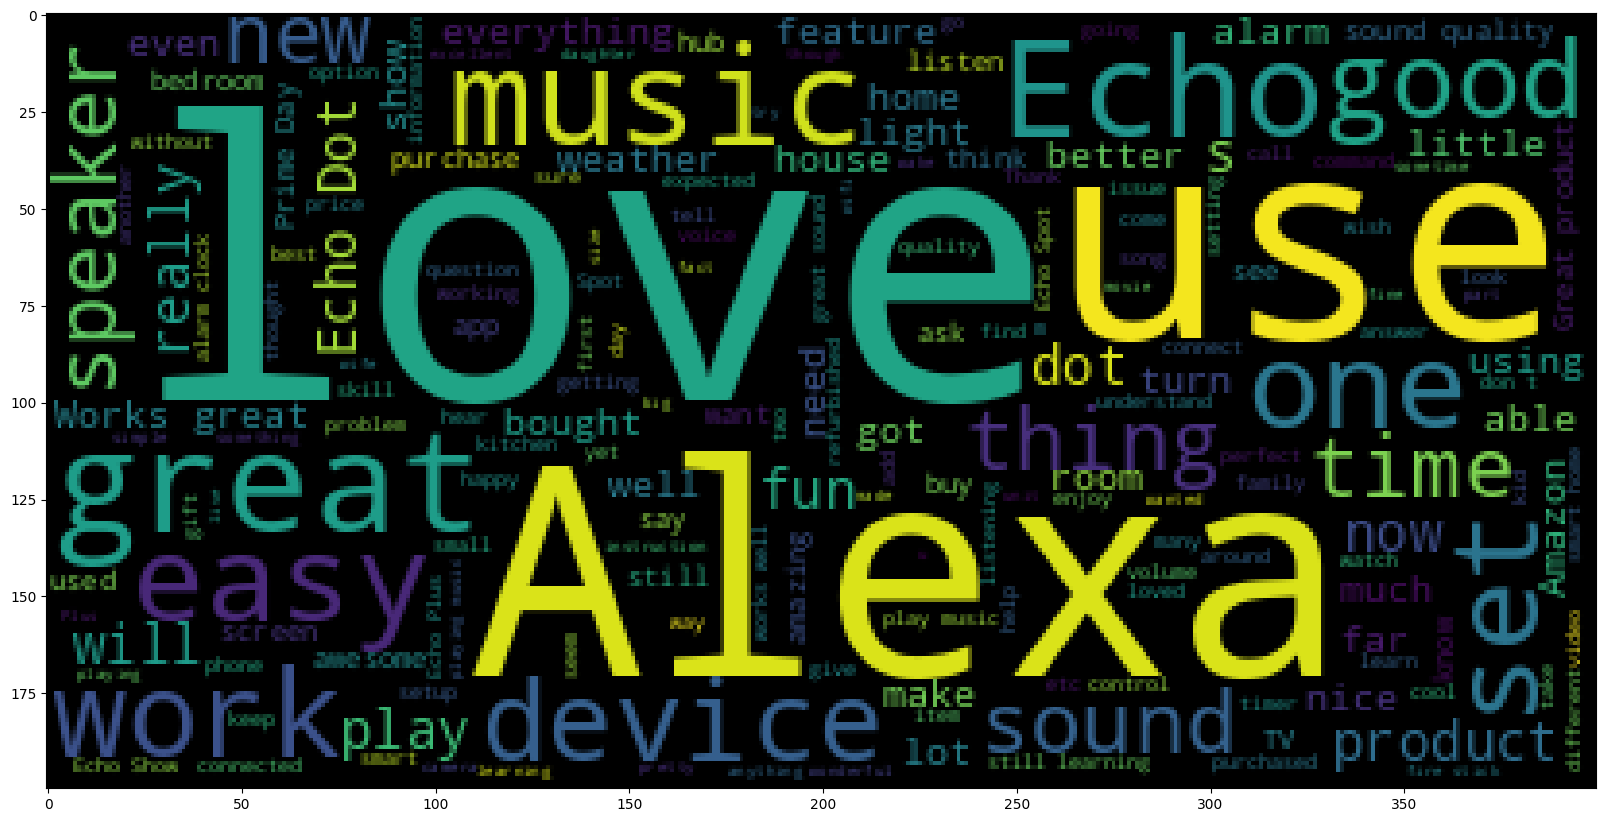

In [7]:
# Generate Word CLoud for Positive Reviews
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(good_str))

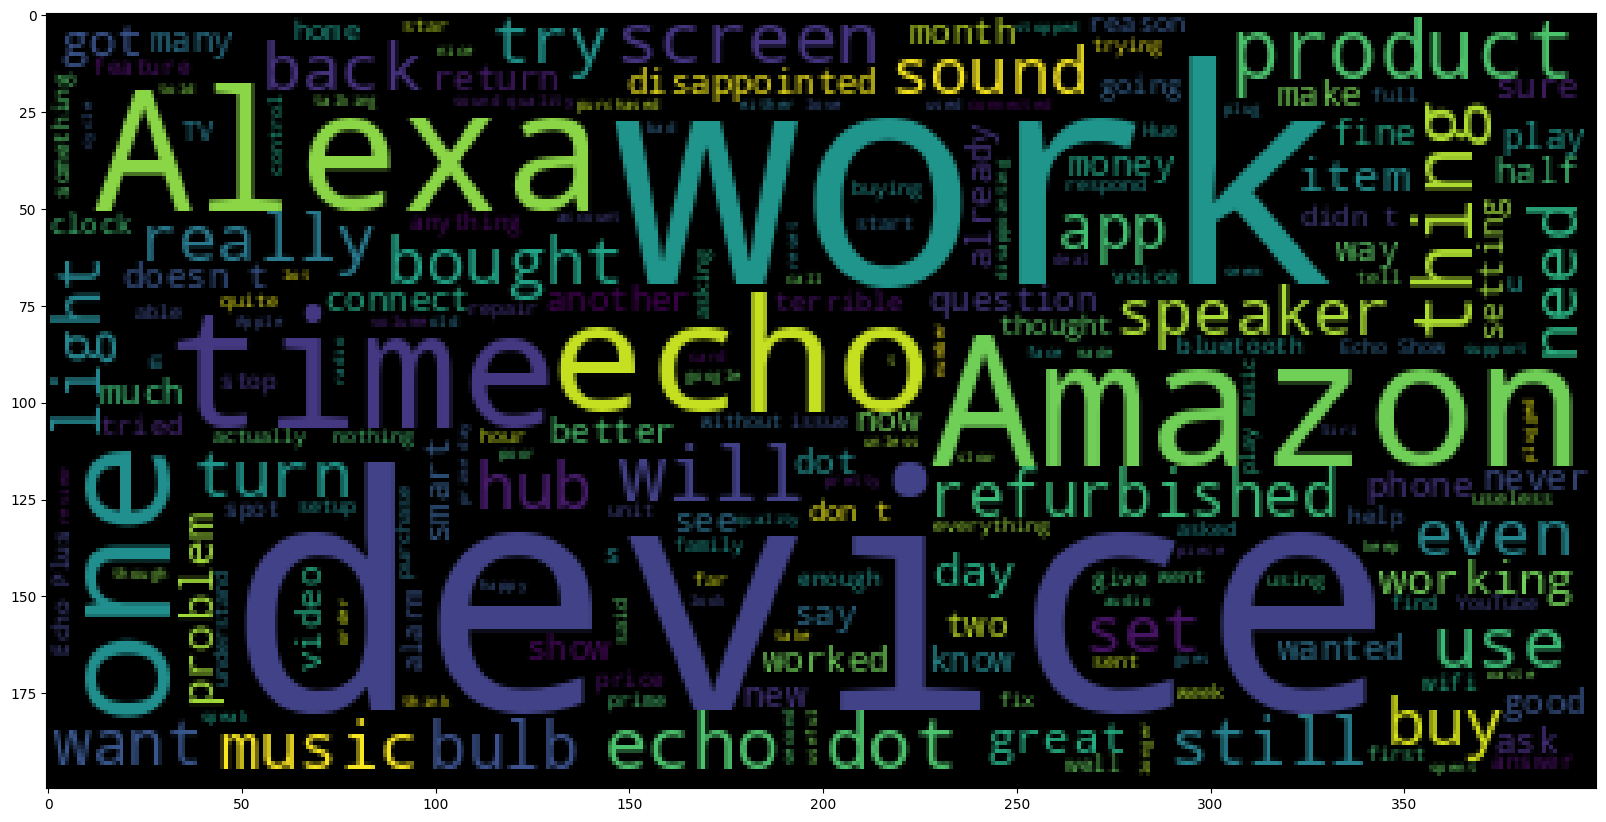

In [8]:
# Generate Word CLoud for Negative Reviews
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(bad_str))

In [9]:
# Removing the extra spaces in the variation column
df['variation'] = df['variation'].str.strip()



In [10]:
#Analyzing the number of each variation of the product
df['variation'].value_counts()

Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64

In [11]:
#Replacing the empty rows and columms with NaN and deleting them.
df['verified_reviews'].replace(' ', np.nan, inplace=True)
df.dropna(subset=['verified_reviews'], inplace=True)


<Axes: >

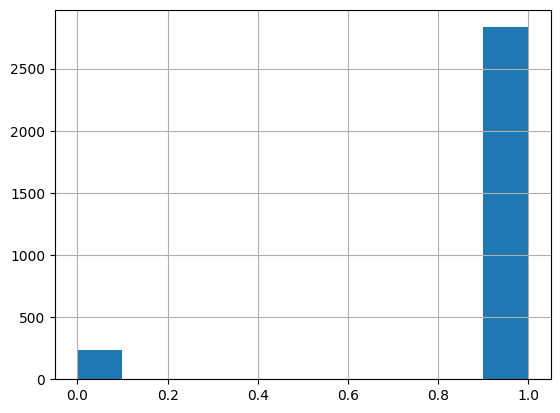

In [12]:
# Assigning the reviews (X) and the feedback as the target (Y)
X = df['verified_reviews']
y = df['feedback']

# Displaying the target column (Y) on a histogram according to the number of positive reviews and negative reviews
y.hist()

#### As seen in the histogram, the target column is imbalanced. Therefore, the column would be balanced using Oversampling. Oversampling is a technique which increases the number of samples of the smallest class up to the size of the biggest class

In [13]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X.values.reshape(-1, 1), y)

In [14]:
# Perform cleaning of the data column as pass this function to the Vectorizer
def preprocessing(message):
    Test_punc_removed = [word for word in message if word not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords and word.lower().isalpha() and word is not None]
    Test_punc_removed_join_clean = ' '.join(Test_punc_removed_join_clean)
    return Test_punc_removed_join_clean

In [15]:
# Reshape the array to a 1D.
X_res = np.ravel(X_res)
X_res.shape
#Convert the Array to a dataframe.
X_res = pd.Series(X_res)

In [16]:
# Divide the balanced target column (Y) and  reviews column (X) to train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    stratify=y_res, 
                                                    test_size=0.25, random_state = 245)



<Axes: >

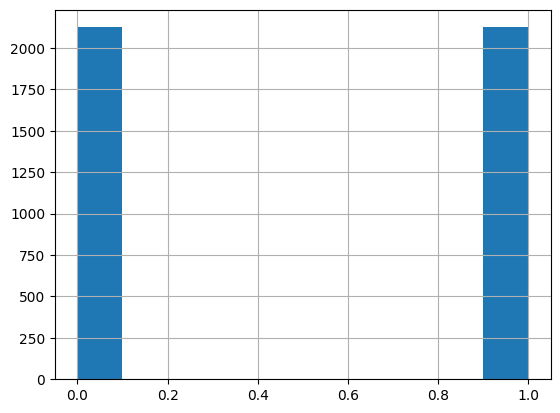

In [17]:
# Convert the y_train to a histogram.
y_train.hist()

In [18]:
# Viewing the shape of the X_train dataset.
X_train.shape

(4249,)

#### We would be using different models to predict the sentiment of the Reviews and test how well the model performed

In [19]:
# Function to evaluate the model's performace
def model_evaluate(model):
    y_pred = model.predict(X_test)
    Pr_train = model.predict_proba(X_train)[:,1]
    Pr_test = model.predict_proba(X_test)[:,1]
    

    print(classification_report(y_test, y_pred))

In [20]:
# Using Tfidf Vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=2000)
# tokenizer=LemmaTokenizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [21]:
# Using BernoulliNB 
BNBmodel = BernoulliNB(alpha = 1)
BNBmodel.fit(X_train, y_train)
model_evaluate(BNBmodel)


              precision    recall  f1-score   support

           0       0.88      0.66      0.75       708
           1       0.73      0.91      0.81       709

    accuracy                           0.78      1417
   macro avg       0.80      0.78      0.78      1417
weighted avg       0.80      0.78      0.78      1417



In [22]:
# Using Logistic Regression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_evaluate(LRmodel)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       708
           1       1.00      0.96      0.98       709

    accuracy                           0.98      1417
   macro avg       0.98      0.98      0.98      1417
weighted avg       0.98      0.98      0.98      1417



In [23]:
test = ["I am not fully into the product"]
test = pd.Series(test)
pred_test = tfidf.transform(test)
LRmodel.predict(pred_test)

array([0], dtype=int64)

In [24]:
# Using a Pipeline in Sklearn to chain the steps of the workflow 

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    stratify=y_res, 
                                                    test_size=0.25, random_state = 245)

pipe = Pipeline([('vectorizer', tfidf),('LRmodel',LRmodel)])
pipe.fit(X_train, y_train)

model_evaluate(pipe)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       708
           1       1.00      0.96      0.98       709

    accuracy                           0.98      1417
   macro avg       0.98      0.98      0.98      1417
weighted avg       0.98      0.98      0.98      1417



In [25]:
# Creating a pickle file to store and retrieve the object for future use
with open('pipeline.pickle','wb') as f:
    pickle.dump(pipe, f)
    
with open('pipeline.pickle', 'rb') as f:
    loaded_pipe = pickle.load(f)
    
model_evaluate(loaded_pipe)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       708
           1       1.00      0.96      0.98       709

    accuracy                           0.98      1417
   macro avg       0.98      0.98      0.98      1417
weighted avg       0.98      0.98      0.98      1417



In [26]:
test = ['I rate this product very very low',
        'I love this project']
test = pd.Series(test)
loaded_pipe.predict(test)

array([0, 1], dtype=int64)

#### The Count Vectorizer will be used and the performace of the model on the dataset will be compared to Tfidf Vectorizer

In [27]:
# Dividing the dataset to train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    stratify=y_res, 
                                                    test_size=0.25, random_state = 245)

In [28]:
def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(doc)
    words_and_tags = nltk.pos_tag(tokens)
    return [wnl.lemmatize(word, pos=get_wordnet_pos(tag)) \
            for word, tag in words_and_tags]

In [29]:
def user_preprocessing(message):
    Test_punc_removed = [word for word in message if word not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords and word.lower().isalpha() and word is not None]
    Test_punc_removed_join_clean = ' '.join(Test_punc_removed_join_clean)
    Test_punc_removed_join_clean= lemma_tokenizer(Test_punc_removed_join_clean)
    # Test_punc_removed_join_clean = list(Test_punc_removed_join_clean)
    return Test_punc_removed_join_clean

In [30]:
def preprocessing(message):
    Test_punc_removed = [word for word in message if word not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords and word.lower().isalpha() and word is not None]
    Test_punc_removed_join_clean = ' '.join(Test_punc_removed_join_clean)
    return Test_punc_removed_join_clean

#### The code sets up a CountVectorizer object with a custom tokenizer function, LemmaTokenizer(), and disables the lowercase option. It then uses the fitted CountVectorizer to transform the training data, X_train, into a document-term matrix and assigns the result to X_train. 

#### Finally, it transforms the test data, X_test, using the same vectorizer object and assigns the result to X_test.

In [31]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), lowercase=False)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

c:\Users\moyin\anaconda3\envs\sentiment\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [32]:
# Shape of the X test dataset
X_test.shape

(1417, 4043)

In [33]:
# Using BernoulliNB 
BNBmodel = BernoulliNB(alpha = 1)
BNBmodel.fit(X_train, y_train)
model_evaluate(BNBmodel)


              precision    recall  f1-score   support

           0       0.87      0.73      0.79       708
           1       0.76      0.89      0.82       709

    accuracy                           0.81      1417
   macro avg       0.82      0.81      0.81      1417
weighted avg       0.82      0.81      0.81      1417



In [34]:
test = ['I strongly hate this product']
test = pd.Series(test)
pred_test = vectorizer.transform(test)
BNBmodel.predict(pred_test)

array([1], dtype=int64)

In [35]:
# Using LogisticRegression
LRmodel = LogisticRegression(C = 2, max_iter = 2000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_evaluate(LRmodel)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       708
           1       1.00      0.96      0.98       709

    accuracy                           0.98      1417
   macro avg       0.98      0.98      0.98      1417
weighted avg       0.98      0.98      0.98      1417



In [36]:
# Using Gradient Boosting Classifier
GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)
model_evaluate(GBC)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       708
           1       0.93      0.90      0.91       709

    accuracy                           0.92      1417
   macro avg       0.92      0.92      0.92      1417
weighted avg       0.92      0.92      0.92      1417



In [37]:
# Using MultinomialNB
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)
model_evaluate(NB_classifier)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       708
           1       0.99      0.94      0.96       709

    accuracy                           0.96      1417
   macro avg       0.97      0.96      0.96      1417
weighted avg       0.97      0.96      0.96      1417



In [38]:
# Using a Pipeline in Sklearn to chain the steps of the workflow 

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    stratify=y_res, 
                                                    test_size=0.25, random_state = 245)

pipe = Pipeline([('vectorizer', vectorizer),('MNB',NB_classifier)])
pipe.fit(X_train, y_train)

model_evaluate(pipe)

c:\Users\moyin\anaconda3\envs\sentiment\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0       0.94      0.99      0.96       708
           1       0.99      0.94      0.96       709

    accuracy                           0.96      1417
   macro avg       0.97      0.96      0.96      1417
weighted avg       0.97      0.96      0.96      1417



In [39]:
# Creating a pickle file to store and retrieve the object for future use
with open('pipeline.pickle','wb') as f:
    pickle.dump(pipe, f)
    
with open('pipeline.pickle', 'rb') as f:
    loaded_vector_pipe = pickle.load(f)
    
model_evaluate(loaded_vector_pipe)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       708
           1       0.99      0.94      0.96       709

    accuracy                           0.96      1417
   macro avg       0.97      0.96      0.96      1417
weighted avg       0.97      0.96      0.96      1417



In [42]:
# A function that performs prediction according to the user input text
def predict(model, user_text):
    # Predict the sentiment
    predictions = model.predict(user_text)
    pred_to_label = {0: 'Negative', 1: 'Positive'}

    # Make a list of user_text with sentiment.
    data = []
    for t, pred in zip(text, predictions):
        data.append((t, pred, pred_to_label[pred]))

    return data


if __name__=="__main__":
    # Text to classify should be in a list.
    text = ["I bought this product thinking it would solve all my problems, but I was sorely disappointed. The quality was poor, and it didn't work as advertised. It broke after a few uses, and the customer service was terrible. I wouldn't recommend this product to anyone",
        "I love this project",
        "I am going to return this product"]
    
    predictions = predict(loaded_vector_pipe, text)
    print(predictions)

[("I bought this product thinking it would solve all my problems, but I was sorely disappointed. The quality was poor, and it didn't work as advertised. It broke after a few uses, and the customer service was terrible. I wouldn't recommend this product to anyone", 0, 'Negative'), ('I love this project', 1, 'Positive'), ('I am going to return this product', 0, 'Negative')]
